# Multi-channel / Multi-spectral Microscopy Classification

A common use-case in (digital) microscopy is multi-channel or multi-spectral imaging, e.g. obtained from multiplexed fluorescence microscopy. This modality is often used in experiments for cancer research, neuroscience or developmental biology.

From a data science / deep learning perspective, classifying such images can be modeled as mapping a multi-channel input to a multi-class output, using a deep neural network architecture like a CNN. Specifically, in this example, we are going to explore an end-to-end training and evaluation example based on a subset of the [Rxrx1]() dataset.The Rxrx1 dataset was released by Recursion in the RxRx.ai series. For more information, please read the original [dataset description](https://www.rxrx.ai/rxrx1#the-data). We are going to use a subset of this data in this tutorial (see details below).

In the remainder of this tutorial, we'll go through the following steps:

- Load a 6-channel fluorescence microscopy dataset for training, validation and testing
- Use MONAI transforms to pre-process 6-channel multi-spectral image data
- Use the DenseNet169 from MONAI for classification (pre-trained on 3-channel/RGB ImageNet data)
- Train the model with a typical PyTorch training loop
- Evaluate on the hold-out test fraction of the dataset

![rxrx1.PNG](https://assets.website-files.com/5cb63fe47eb5472014c3dae6/5d0420ae89e22f591a352639_figure6.png)

(Image source: Rxrx1 website, Figure 6, https://www.rxrx.ai/rxrx1#the-data)

## Setting up environment and imports

In [3]:
# imports
import os
import pprint
import pandas as pd
import matplotlib.pyplot as plt

import torch
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import Dataset, CacheDataset, DataLoader, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet169
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    ConcatItemsd,
    LoadImaged,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    ScaleIntensityRangePercentilesd,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.0.1
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.5.3
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.5.0
transformers version: 4.21.3
mlflow version: 1.30.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Download Rxrx1 subset data

The original Rxrx1 dataset is very large (45 GB) and designed for prediction of more than 1000 classes. To avoid lengthy download times, we will utilize a subset of Rxrx1, which was sampled in a random and balanced manner. For practical purposes, the classification target is changed from `sirna_id` (>1000 classes) to `cell_type` (4 classes). For each of the 4 cell types (HEPG2/HUVEC/RPE/U2OS), 250 samples were randomly selected for training (1000 samples total) and 50 for testing (200 samples total). 

We are first going to download the dataset and then load the `metadata.csv` table to create training and test dataframes.

**Note:** The original Rxrx1 sample indices are stored in the column `original_row_index` in file `./rxrx1_subset_monai/metadata.csv`.


In [2]:
url = 'https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/rxrx1_subset_monai.zip'
download_and_extract(
    url,
    filepath='./rxrx1_subset_monai.zip',
    output_dir='.',
    hash_val='5eea02f6b0a6d8cbce6ad66949257438'
)

rxrx1_subset_monai.zip: 468MB [00:43, 11.4MB/s]                              


2022-12-16 09:11:03,254 - INFO - Downloaded: rxrx1_subset_monai.zip
2022-12-16 09:11:04,649 - INFO - Verified 'rxrx1_subset_monai.zip', md5: 5eea02f6b0a6d8cbce6ad66949257438.
2022-12-16 09:11:04,650 - INFO - Writing into directory: ..


## Prepare dataframes and datalists

We use `pandas` to read the `metadata.csv` file and split the data into train/test sets.

In [4]:
df_all = pd.read_csv('./rxrx1_subset_monai/metadata.csv')
dftrain = df_all.loc[df_all.dataset == 'train', :].reset_index()
dftest = df_all.loc[df_all.dataset == 'test', :].reset_index()

class_map = {c: idx for idx, c in enumerate(dftrain.cell_type.unique())}
class_map_inv = {idx: c for idx, c in enumerate(dftrain.cell_type.unique())}
num_classes = len(class_map)
class_names = list(class_map.keys())

print(dftrain.columns)
dftrain

Index(['index', 'original_row_index', 'site_id', 'well_id', 'cell_type',
       'dataset', 'experiment', 'plate', 'well', 'site', 'well_type', 'sirna',
       'sirna_id'],
      dtype='object')


,index,original_row_index,site_id,well_id,cell_type,dataset,experiment,plate,well,site,well_type,sirna,sirna_id
0,0,45589,HEPG2-01_3_C15_2,HEPG2-01_3_C15,HEPG2,train,HEPG2-01,3,C15,2,positive_control,s15652,1114
1,1,59951,HEPG2-07_2_H02_2,HEPG2-07_2_H02,HEPG2,train,HEPG2-07,2,H02,2,treatment,s195435,683
2,2,48708,HEPG2-02_4_D13_1,HEPG2-02_4_D13,HEPG2,train,HEPG2-02,4,D13,1,treatment,s20197,85
3,3,46896,HEPG2-02_1_E09_1,HEPG2-02_1_E09,HEPG2,train,HEPG2-02,1,E09,1,treatment,s27069,313
4,4,60402,HEPG2-07_3_D09_1,HEPG2-07_3_D09,HEPG2,train,HEPG2-07,3,D09,1,treatment,s18250,405
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,123921,U2OS-03_2_G21_2,U2OS-03_2_G21,U2OS,train,U2OS-03,2,G21,2,treatment,s37346,1046
996,996,121453,U2OS-02_2_G19_2,U2OS-02_2_G19,U2OS,train,U2OS-02,2,G19,2,treatment,s38759,164
997,997,119034,U2OS-01_2_H20_1,U2OS-01_2_H20,U2OS,train,U2OS-01,2,H20,1,treatment,s21714,785
998,998,118168,U2OS-01_1_C05_1,U2OS-01_1_C05,U2OS,train,U2OS-01,1,C05,1,treatment,s19455,999


### Create datalists for training and validation
These are lists of dictionaries, with image dict-keys pointing to filepaths, plus a label dict-key.

To construct the filepaths, we follow the same folder- and filenaming pattern from the full Rxrx1 dataset.

(Note: For details, please find instructions in [./rxrx1_subset_monai/README.md#metadata](./rxrx1_subset_monai/README.md#metadata))

In [5]:
base_path_rxrx1 = os.path.join('.', 'rxrx1_subset_monai')
datalists = []
for df in [dftrain, dftest]:
    datalist = []
    for row in range(df.shape[0]):
        d = {}
        s = df.loc[row, :]
        filepaths = []
        for c in [1, 2, 3, 4, 5, 6]:
            subpath = os.path.join('images', s.experiment, f'Plate{s.plate}')
            fn = f'{s.well}_s{s.site}_w{c}.png'
            d[f'c{c}'] = os.path.join(base_path_rxrx1, subpath, fn)
        d['label'] = class_map[s.cell_type]
        datalist.append(d)
    datalists.append(datalist)
datalist_train, datalist_test = tuple(datalists)

# print 3 example train samples
pp = pprint.PrettyPrinter()
pp.pprint(datalist_train[:3])

[{'c1': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w1.png',
  'c2': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w2.png',
  'c3': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w3.png',
  'c4': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w4.png',
  'c5': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w5.png',
  'c6': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w6.png',
  'label': 0},
 {'c1': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w1.png',
  'c2': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w2.png',
  'c3': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w3.png',
  'c4': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w4.png',
  'c5': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w5.png',
  'c6': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w6.png',
  'label': 0},
 {'c1': './rxrx1_subset_monai/images/HEPG2-02/Plate4/D13_s1_w1.png',
  'c2': './rxrx1_subset_monai/images/HEPG2-02/Plate4/D13_s1_w2.png',
  'c

## Writing a custom image converter for visualization

For visualization of the 6-channel images, we need to convert them to RGB (3-channel) images first. <br>
We write a custom function, which assumes 6-channel image inputs (as channel-first). <br>
For conversion of channels to colors, we follow the color-mapping described and visualized on the Rxrx1 website (i.e. Figure 6 in https://www.rxrx.ai/rxrx1#the-data):

- Nuclei -> blue
- Endoplasmic reticuli -> green
- Actin -> red
- Nucleoli -> cyan
- Mitochondria -> magenta
- Golgi apparatus -> yellow

In [6]:
def img_6to3_channel(img6ch):
    img = torch.zeros((img6ch.shape[1], img6ch.shape[2], 3))
    # nuclei (blue)
    img[:, :, 2] += img6ch[0, :, :]
    # endoplasmic reticuli (green)
    img[:, :, 1] += img6ch[1, :, :]
    # actin (red)
    img[:, :, 0] += img6ch[2, :, :]
    # nucleoli (cyan)
    img[:, :, 1] += img6ch[3, :, :]
    img[:, :, 2] += img6ch[3, :, :]
    # mitochondria (magenta)
    img[:, :, 0] += img6ch[4, :, :]
    img[:, :, 2] += img6ch[4, :, :]
    # golgi apparatus (yellow)
    img[:, :, 0] += img6ch[5, :, :]
    img[:, :, 1] += img6ch[5, :, :]
    # normalize RGB channels
    img = img / 3.0
    return img

## Robust multi-channel normalization during pre-processing

Each multi-spectral channel has a different range of intensities, and there might be variation across the multi-well plates, across batches, or across experiments. If not properly accounted for, the input to the neural networks has a lot of variation in the individual channels which might affect classification performance.

In the following two code cells, we are going to load a few sample images, and visualize them in two ways:
1. Without any pre-processing (note: when passing multi-spectral images to the visualization function, we still need to divide intensities by 255.0, to bring pixels from the range [0, 255] to the expected color range [0.0, 1.0]).
2. With a more suitable pre-processing: robust normalization of the [1,99]-percentile intensity ranges, individually per channel, to the output range [0.0, 1.0] (with clipping). This process is also called [winsorization](https://en.wikipedia.org/wiki/Winsorizing) and is a useful technique for robust intensity normalization in medical imaging. We use the intensity transform [`ScaleIntensityRangePercentilesd`](https://docs.monai.io/en/stable/transforms.html#scaleintensityrangepercentilesd) from MONAI Core for winsorization.

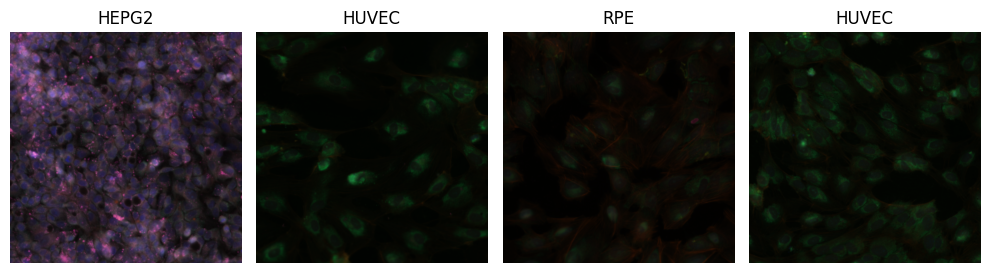

In [7]:
# visualize test batch without normalization
set_determinism(seed=0)
transforms_visualize = Compose([
    LoadImaged(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], image_only=True),
    EnsureChannelFirstd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6']),
    ConcatItemsd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], name='image', dim=0)
])

batch_size_viz = 4
viz_ds = Dataset(
    datalist_train, transform=transforms_visualize)
viz_loader = DataLoader(
    viz_ds, batch_size=batch_size_viz, shuffle=True, num_workers=0)
batch_data = next(iter(viz_loader))

fig, axs = plt.subplots(1, batch_size_viz, figsize=(10, 10 * batch_size_viz), dpi=100)
for idx, img6ch in enumerate(batch_data['image']):
    axs[idx].imshow(img_6to3_channel(img6ch) / 255.0)
    axs[idx].set_axis_off()
    axs[idx].set_title(class_map_inv[int(batch_data['label'][idx])])
fig.set_tight_layout(True)
# fig.savefig('./batch_without_normalization.png',bbox_inches='tight')
plt.show()

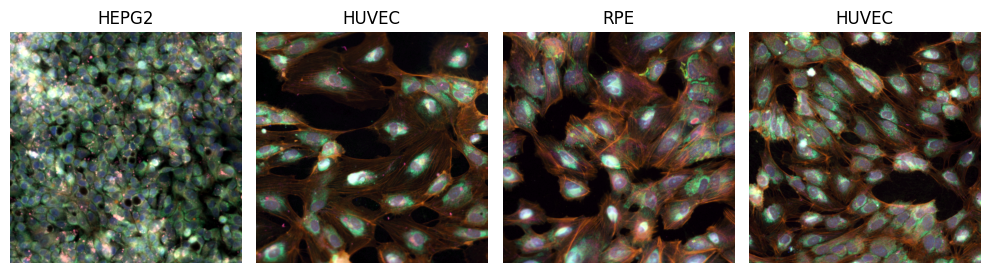

In [8]:
# visualize test batch with normalization
set_determinism(seed=0)
transforms_visualize = Compose([
    LoadImaged(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], image_only=True),
    EnsureChannelFirstd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6']),
    ScaleIntensityRangePercentilesd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],
                                    lower=1.0, upper=99.0,
                                    b_min=0.0, b_max=1.0,
                                    clip=True),
    ConcatItemsd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], name='image', dim=0)
])

batch_size_viz = 4
viz_ds = Dataset(
    datalist_train, transform=transforms_visualize)
viz_loader = DataLoader(
    viz_ds, batch_size=batch_size_viz, shuffle=True, num_workers=0)
batch_data = next(iter(viz_loader))

fig, axs = plt.subplots(1, batch_size_viz, figsize=(10, 10 * batch_size_viz), dpi=100)
for idx, img6ch in enumerate(batch_data['image']):
    axs[idx].imshow(img_6to3_channel(img6ch))
    axs[idx].set_axis_off()
    axs[idx].set_title(class_map_inv[int(batch_data['label'][idx])])
fig.set_tight_layout(True)
# fig.savefig('./batch_with_normalization.png',bbox_inches='tight')
plt.show()

## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Create transforms, CacheDataset and DataLoader

In [9]:
transforms_train = Compose([
    LoadImaged(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], image_only=True),
    EnsureChannelFirstd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6']),
    ScaleIntensityRangePercentilesd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],
                                    lower=1.0, upper=99.0,
                                    b_min=0.0, b_max=1.0,
                                    clip=True),
    ConcatItemsd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], name='image', dim=0),
    EnsureTyped(keys=["image", "label"], track_meta=False),
    RandRotate90d(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],
                  prob=0.75),
    RandFlipd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],
              spatial_axis=[0, 1],
              prob=0.5),
    RandZoomd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],
              min_zoom=0.9,
              max_zoom=1.1,
              prob=0.5),
])

transforms_val = Compose([
    LoadImaged(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], image_only=True),
    EnsureChannelFirstd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6']),
    ScaleIntensityRangePercentilesd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],
                                    lower=1.0, upper=99.0,
                                    b_min=0.0, b_max=1.0,
                                    clip=True),
    ConcatItemsd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], name='image', dim=0),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_classes)])

batch_size_train = 8
train_ds = CacheDataset(
    datalist_train, transform=transforms_train, num_workers=10)
train_loader = ThreadDataLoader(
    train_ds, batch_size=batch_size_train, shuffle=True)

Loading dataset: 100%|██████████| 1000/1000 [02:26<00:00,  6.83it/s]


## Define the model, loss and optimizer

For the model, we use the [DenseNet169](https://docs.monai.io/en/stable/networks.html#densenet169) architecture from MONAI Core. It allows to specify the number of input channels at constructor level with the `in_channels` parameter (e.g. grayscale: 1, RGB: 3, multiplexed fluoroscopy: 6).

It also allows to load weights that were pre-trained on ImageNet, effectively turning this into a transfer learning task.

In [10]:
device = 'cuda:0'
model = DenseNet169(spatial_dims=2, in_channels=6,
                    out_channels=num_classes,
                    pretrained=True)
# Note: In the DenseNet169 constructor, the parameter in_channels=6 already adds a
#       6-channel input layer to the network and connects it to the following
#       ImageNet-pretrained layers. Alternatively, we could also manually replace
#       the first convolutional layer as such: 
# first_conv = nn.Conv2d(6, 64, 7, 2, 3, bias=False)
# model.features.conv0 = first_conv
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

## Execute a typical PyTorch training loop

Note: Typically, one would use a validation set to observe overfitting. For simplicity, we are skipping this here, but you can refer to other tutorials for an example, e.g. the [mednist_tutorial.ipynb](../2d_classification/mednist_tutorial.ipynb).

In [11]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs = batch_data['image'].to(device)
        labels = batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/4
1/125, train_loss: 1.3522
2/125, train_loss: 1.4703
3/125, train_loss: 1.4035
4/125, train_loss: 1.3636
5/125, train_loss: 1.3242
6/125, train_loss: 1.3899
7/125, train_loss: 1.2963
8/125, train_loss: 1.3937
9/125, train_loss: 1.3283
10/125, train_loss: 1.3073
11/125, train_loss: 1.2005
12/125, train_loss: 1.2428
13/125, train_loss: 1.3436
14/125, train_loss: 1.3148
15/125, train_loss: 1.1799
16/125, train_loss: 1.2771
17/125, train_loss: 1.2564
18/125, train_loss: 1.1697
19/125, train_loss: 1.2812
20/125, train_loss: 1.3650
21/125, train_loss: 1.1827
22/125, train_loss: 1.2452
23/125, train_loss: 1.1328
24/125, train_loss: 1.1649
25/125, train_loss: 1.2532
26/125, train_loss: 1.1453
27/125, train_loss: 1.0380
28/125, train_loss: 1.1414
29/125, train_loss: 1.1090
30/125, train_loss: 1.2730
31/125, train_loss: 1.1956
32/125, train_loss: 1.1595
33/125, train_loss: 1.0927
34/125, train_loss: 1.1042
35/125, train_loss: 0.9893
36/125, train_loss: 1.1272
37/125, train_lo

## Evaluation on test set and classification report

We can now evaluate the trained model on the hold-out test set. 

In [12]:
batch_size_test = 32
test_ds = Dataset(
    datalist_test, transform=transforms_val)
test_loader = DataLoader(
    test_ds, batch_size=batch_size_test, shuffle=False, num_workers=4)

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['image'].to(device),
            test_data['label'].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       HEPG2     0.9615    1.0000    0.9804        50
       HUVEC     0.9804    1.0000    0.9901        50
         RPE     0.9434    1.0000    0.9709        50
        U2OS     1.0000    0.8800    0.9362        50

    accuracy                         0.9700       200
   macro avg     0.9713    0.9700    0.9694       200
weighted avg     0.9713    0.9700    0.9694       200



Cell-type classification works at a high accuracy (f1-score: 0.97) on this simple example. To a degree, this is due to the fact that we performed transfer learning with our DenseNet CNN, using weights that were pre-trained on ImageNet. 

Feel free to re-run training, but without transfer learning (i.e. `model = DenseNet169(..., pretrained=False)`), and observe how the classification accuracy changes.